In [3]:
import keras
keras.__version__

'2.2.4'

# 주택 가격 예측: 회귀 문제

## 보스턴 주택 가격 데이터셋


*** 
### 데이터셋 추가 정보
- 카네기 멜런 대학교에서 제공하는 데이터셋
- 레코드수 : 506 개 
- 필드개수 :  14 개 
- 보스턴 시의 주택 가격에 대한 데이터이다. 
- 주택의 여러가진 요건들과 주택의 가격 정보가 포함되어 있다.
- 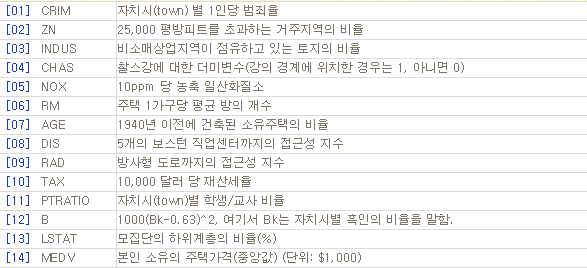

### 예측하고자 하는 방법
- 입력 데이터 포인트의 개별적인 레이블 하나를 예측하는 것이 목적
- 모델은 mse 손실 함수(평균 제곱 오차(mean squared error)의 약자로 예측과 타깃 사이 거리의 제곱)를 사용하여 컴파일
- 데이터를 K개의 분할(즉, 폴드)로 나누고(일반적으로 K = 4 또는 5), K개의 모델을 각각 만들어 K - 1개의 분할에서 훈련하고 나머지 분할에서 평가(테스트)
    - 모델의 검증 점수는 K 개의 검증 점수의 평균
- 과대적합을 피하기 위해 은닉층의 수를 줄임
- test_mae_score를 통해 훈련시킨 모델의 성능을 파악

### 학습을 위해 데이터가 어떻게 가공/처리 되었는지?
- 상이한 스케일을 가진 값을 신경망에 주입하면 문제가 되므로 데이터를 특성별로 정규화
- 입력 데이터에 있는 각 특성(입력 데이터 행렬의 열)에 대해서 특성의 평균을 빼고 표준 편차로 나누기(정규화). 특성의 중앙이 0 근처에 맞춰지고 표준 편차가 1이 됨
- 64개의 은닉 유닛을 가진 Dense Layer 2번(활성함수 relu) -> 1개의 은닉 유닛을 가진 Dense Layer(활성화 함수 없음)을 통과

- 데이터를 훈련 세트와 검증 세트로 나누기. 데이터 포인트가 많지 않기 때문에 검증 세트도 매우 작아짐.(약 100개의 샘플)
    - 검증 세트와 훈련 세트로 어떤 데이터 포인트가 선택됐는지에 따라 검증 점수가 크게 달라지므로 K-겹 검증을 통한 훈련 검증을 함
    
### 사용된 모델의 입력층과 출력층
- 입력층: 64개의 은닉 유닛을 가진 Dense Layer. 활성함수는 relu
- 출력층: 1개의 은닉 유닛을 가지고 있고 활성화 함수가 없는 Dense Layer. (선형 층), 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성. 마지막 층이 순수한 선형이므로 네트워크가 어떤 범위의 값이라도 예측하도록 자유롭게 학습될 수 있음.

***


In [4]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) =  boston_housing.load_data()

In [5]:
train_data.shape

(404, 13)

In [6]:
test_data.shape

(102, 13)

In [7]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 준비

In [9]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 모델 구성

In [10]:
from keras import models
from keras import layers

def build_model():
    # 동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용합니다
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-겹 검증을 사용한 훈련 검증

In [12]:
import numpy as np

k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    # 검증 세트로 모델 평가
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [13]:
all_scores

[2.100985571889594, 2.3486677514444483, 3.016376493000748, 2.4823205954957714]

In [14]:
np.mean(all_scores)

2.48708760295764

In [15]:
from keras import backend as K

# 메모리 해제
K.clear_session()

In [16]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]

    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    # 케라스 모델 구성(컴파일 포함)
    model = build_model()
    # 모델 훈련(verbose=0 이므로 훈련 과정이 출력되지 않습니다)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [17]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [18]:
import matplotlib.pyplot as plt

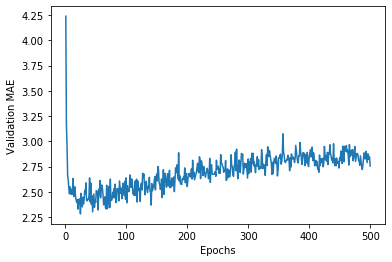

In [19]:
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

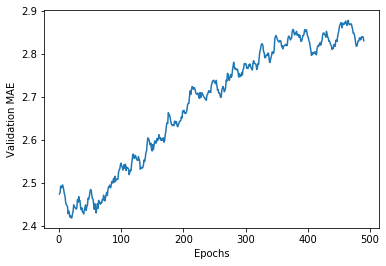

In [32]:
def smooth_curve(points, factor=0.9):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [33]:
# 새롭게 컴파인된 모델을 얻습니다
model = build_model()
# 전체 데이터로 훈련시킵니다
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 518us/step


In [34]:
test_mae_score

2.490308041666068